# Setting

In [2]:
from pf_utils import BacktestManager

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import FinanceDataReader as fdr
import pandas as pd
#import warnings

#warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
path_data = 'data'

## Implement

In [97]:
import os, time
from datetime import datetime


def print_runtime(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Execution time of {func.__name__}: {end_time - start_time:.2f} secs")
        return result
    return wrapper
        

class Kospi200():
    def __init__(self, file=None, path='.'):
        self.file_historicals = file
        self.path = path
        self.df_prices = None

    def load(self):
        file = self.file_historicals
        if file is None:
            return print('ERROR: no file to load.')
        else:
            path = self.path
        self.df_prices = pd.read_csv(f'{path}/{file}', parse_dates=[0], index_col=[0])


    def update(self, col_ticker='Code', symbol='KRX/INDEX/STOCK/1028'):
        df_prices_old = self.df_prices
        if df_prices_old is None:
            return print('ERROR: load df_prices first')

        # get lastest tickers
        tickers = fdr.SnapDataReader(symbol) 
        #if tickers is None:
        if len(tickers) == 0:
            return print('ERROR: failed to get tickers')
        else:
            tickers = pd.Index(tickers[col_ticker])

        return (tickers, df_prices_old) # testing
        
        df_prices = self._update_existing(tickers, df_prices_old)
        df_prices = self._update_new(tickers, df_prices)
        return df_prices

    
    @print_runtime
    def _update_existing(self, tickers, df_prices_old):
        """
        update existing tickers
        symbol: 'KRX/INDEX/STOCK/1028' for 코스피 200
        """
        tickers = tickers.intersection(df_prices_old.columns)
        df_prices = df_prices_old[tickers]
        
        date_from = df_prices.index.max()
        df_prices_new = fdr.DataReader(tickers, date_from)
        
        # check if adjusted
        err = df_prices_new.iloc[0]/df_prices.iloc[-1] - 1
        print(f'{err.mean()*100:.0f} ± {err.std()*100:.2f}')

        return pd.concat([df_prices, df_prices_new.iloc[1:]])

    
    @print_runtime
    def _update_new(self, tickers, df_prices):
        tickers = tickers.difference(df_prices.columns)
        if len(tickers) == 0:
            return df_prices
        else:
            date_from = df_prices.index.min()
            df_prices_new = fdr.DataReader(tickers, date_from)
            return df_prices.join(df_prices_new)


    def save(self, file=None, path=None):
        file = self._check_var(file, self.file_historicals)
        path = self._check_var(path, self.path)
        df_prices = self.df_prices
        if (file is None) or (df_prices is None):
            return print('ERROR: check file or df_prices')

        f = os.path.join(path, file)
        while os.path.exists(f):
            today = datetime.now().strftime('%y%m%d')
            name, ext = os.path.splitext(f)
            f = f'{name}_{today}{ext}'

        df_prices.to_csv(f)    
        print(f'{f} saved.')
        
    def _check_var(self, var_arg, var_self):
        return var_self if var_arg is None else var_arg


### testing

In [101]:
k2h = Kospi200('df_200.csv', path_data)
k2h.load()
df_prices = k2h.df_prices

In [88]:
%%time
df_prices.tail()

CPU times: user 234 μs, sys: 43 μs, total: 277 μs
Wall time: 243 μs


,051600,001040,001440,316140,004800,028260,192080,383220,036460,185750,...,011170,004020,012750,032830,003620,039130,105560,021240,192820,009420
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-19,37200,124800,15700,14140,57300,135400,44500,65100.0,55800,100400,...,112300,28950,58700,87400,5340,57000,78900,55200,187100,33000
2024-06-20,36900,122600,15610,14360,57200,135100,45700,64400.0,63500,101600,...,120500,29350,59500,87600,5310,57400,80800,55900,180000,33000
2024-06-21,37200,125500,16240,14240,57800,135300,45400,63000.0,61900,94600,...,115000,29600,57600,87000,5250,59600,78600,58200,187000,33350
2024-06-24,37300,117000,15680,14490,57200,135900,45750,62200.0,63500,95800,...,115000,28950,56800,87000,5170,58500,80000,58000,184100,32300
2024-06-25,37200,117500,15800,14580,57200,135400,47050,62800.0,62000,96600,...,117400,29200,57600,87800,5210,59000,79900,59700,186700,32600


In [102]:
df_prices2 = k2h.update()

In [103]:
(tickers, df_prices_old) = df_prices2

#def _update_existing(self, tickers, df_prices_old):

tickers = tickers.intersection(df_prices_old.columns)
df_prices = df_prices_old[tickers]

date_from = df_prices.index.max()
df_prices_new = fdr.DataReader(tickers, date_from)

# check if adjusted
err = df_prices_new.iloc[0]/df_prices.iloc[-1] - 1
print(f'{err.mean()*100:.0f} ± {err.std()*100:.2f}')

#return pd.concat([df_prices, df_prices_new.iloc[1:]])

-0 ± 1.67


In [107]:
(df_prices_new.iloc[0] == df_prices.iloc[-1]).sum()

8

005930     80700.0
000660    218500.0
373220    335000.0
005380    288000.0
207940    735000.0
            ...   
285130     49450.0
009900     14180.0
016380      6480.0
005250     14390.0
000670    343500.0
Name: 2024-06-25 00:00:00, Length: 200, dtype: float64

In [31]:
k2h.save()

In [4]:
tickers_200 = fdr.SnapDataReader('KRX/INDEX/STOCK/1028') # 코스피 200

In [6]:
file = 'tickers_kospi200_240704.csv'
tickers_200.to_csv(f'{path_data}/{file}')

,Code,Name,Close,RateCode,ComparedRate,Rate,Marcap


In [ ]:
file = 'tickers_kospi200_240704.csv'
tickers_200 = pd.read_csv(f'{path_data}/{file}')

In [7]:
def load_tickers(file, path='.', update=True, symbol='KRX/INDEX/STOCK/1028'):
    """
    symbol: 'KRX/INDEX/STOCK/1028' for kospi200
    """
    df_tickers = pd.read_csv(f'{path}/{file}',  parse_dates=[0], index_col=[0])


    
    if update:
        df_tickers_new = fdr.SnapDataReader(symbol)
        #tickers = tickers_200.Code
        #df_200 = fdr.DataReader(tickers, '2021')
        if len()
    return df_tickers


file = 'df_200.csv'
df_200 = load_tickers(file, path_data)

No data found


In [62]:
(df_prices.iloc[-1] != df_prices.iloc[-2]).sum()

191

In [67]:
err = df_prices.iloc[-1] / df_prices.iloc[-2] - 1
err.agg(['mean', 'std'])

mean    0.007649
std     0.013509
dtype: float64

In [68]:
print(err.agg(['mean', 'std']))

mean    0.007649
std     0.013509
dtype: float64


In [69]:
err.mean()

0.0076491836511528135

In [71]:
tickers = ['005930', '000660']
fdr.DataReader(tickers, '20240701')

,005930,000660
Date,,
2024-07-01,81800,235500
2024-07-02,81800,232000
2024-07-03,81800,236000
2024-07-04,84400,229000


In [72]:
fdr.DataReader(tickers, '20240629')

,005930,000660
Date,,
2024-07-01,81800,235500
2024-07-02,81800,232000
2024-07-03,81800,236000
2024-07-04,84500,229000


# KOSPI 200

## Data

In [5]:
file = 'df_200.csv'
df_200 = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=[0])

## Backtest

In [5]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246
)
bm = BacktestManager(df_200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)


In [6]:
name = 'KOSPI'
ticker = '069500'
df_kospi = bm.util_import_data(ticker, name=name)

In [7]:
bm.benchmark(df_kospi)

RunOnce selected


In [8]:
kwargs_build = dict(
    name = 'Momentum',
    freq = 'M', select = 'Momentum', weigh = 'ERC',
    n_assets=5, lookback=12, lag=12
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KOSPI, Momentum


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]

Returning stats


,KOSPI,Momentum
start,2021-01-03 00:00:00,2021-01-03 00:00:00
end,2024-06-25 00:00:00,2024-06-25 00:00:00
total_return,0.014736,5.194817
cagr,0.004219,0.690307
calmar,0.012322,2.492977
max_drawdown,-0.342432,-0.276901
avg_drawdown,-0.08767,-0.05618
avg_drawdown_days,209.0,17.232558
daily_vol,0.17231,0.381714
daily_sharpe,0.110941,1.595068


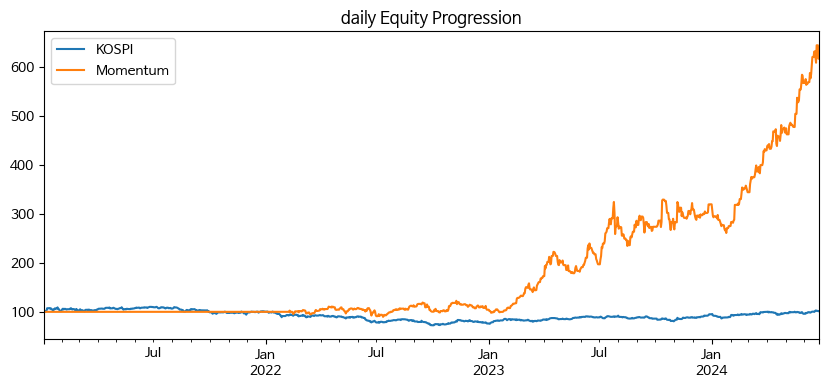

In [9]:
bm.run(figsize=(10,4))

In [17]:
df1 = bm.get_balance(1)
df1

Quantity of securities 2024-06-14


Security
003230     22
010120     60
022100    253
042700     65
267260     45
Name: Volume, dtype: int64

In [26]:
df = bm.df_assets.loc['2024-06-14', df1.index].mul(df1)
df.sort_index()/df.sum()

Security
003230    0.231379
010120    0.194089
022100    0.172318
042700    0.190082
267260    0.212132
dtype: float64

In [29]:
df = bm.get_security_weights(1, stack=True)
df.iloc[-5:].sort_index()

Momentum: weights at transactions returned


Date              
2024-06-14  003230    0.229132
            010120    0.192205
            022100    0.170645
            042700    0.188237
            267260    0.210073
dtype: float64